# Classifier architecture design
Have a couple of ideas to play with here. Let's give the following a college try:

- **Tiling**: Break the data into overlapping chunks by fragment length. Then train a classifier on each chunk. A given fragment will then fall in the length range of n classifiers. Combine the outputs somehow in a clever way, could even train a second tier of classifiers that take the output from the first stages to make the final prediction.
- **Clustering**: Can we somehow cluster text by similarity and then train a classifier for each cluster?
- **Bagging**: Train n classifiers on n random subsets of the data. Then a 'master' classifier to combine the outputs.
- Plot feature importance.
- Plot binary cross-entropy vs fragment length.
- Try other hyperparameter optimization methods.

Note about the classifier: will be using XGBoost - it's the fastest of the bunch from the preliminary classifier selection results and, after optimization has the best balance of false positive and false negative rates. This can obviously be re-evaluated later, but for now, it's a good starting point.

In [1]:
# Turn sampling on or off for rapid development
sample = False

# Change working directory to parent so we can import as we would from main.py
%cd ..

import pickle
import cupy as cp
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from functools import partial
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import train_test_split, cross_validate
from hyperopt.pyll.base import scope
from hyperopt import fmin, tpe, hp, Trials

import configuration as config
import functions.notebook_helper as helper_funcs
import functions.notebook_plotting as plot_funcs

# Set cupy CUDA device to GPU 0 (this is the GTX1070 on pyrite)
cp.cuda.Device(0).use()

/mnt/arkk/llm_detector/classifier


<CUDA Device 0>

## 1. Load and prepare data
Let's take a look:

In [2]:
with open(config.FEATURE_ENGINEERING_CLASS_INSTANCE, 'rb') as file:
    data = pickle.load(file)

data.training.all.combined.info()
print()
data.training.all.combined.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14015 entries, 0 to 14014
Data columns (total 25 columns):
 #   Column                                                                            Non-Null Count  Dtype  
---  ------                                                                            --------------  -----  
 0   Source record num                                                                 14015 non-null  int64  
 1   Fragment length (words)                                                           14015 non-null  int64  
 2   Fragment length (tokens)                                                          14015 non-null  int64  
 3   Dataset                                                                           14015 non-null  object 
 4   Source                                                                            14015 non-null  object 
 5   Generator                                                                         14015 non-null  object 
 6 

,Source record num,Fragment length (words),Fragment length (tokens),Dataset,Source,Generator,String,Perplexity,Cross-perplexity,Perplexity ratio score,...,Human-synthetic perplexity ratio exponential gaussian fit Kullback-Leibler score,Synthetic-human perplexity ratio kernel density estimate Kullback-Leibler score,Human-synthetic perplexity ratio kernel density estimate Kullback-Leibler score,Human TF-IDF,Synthetic TF-IDF,TF-IDF score,Synthetic-human TF-IDF exponential gaussian fit Kullback-Leibler score,Human-synthetic TF-IDF exponential gaussian fit Kullback-Leibler score,Synthetic-human TF-IDF kernel density estimate Kullback-Leibler score,Human-synthetic TF-IDF kernel density estimate Kullback-Leibler score
0,1716,358,483,cnn,synthetic,falcon7,"looked set for 23, while the dovish Israel Bei...",2.127,2.605469,0.816342,...,0.363637,3.462912,0.330010,-3.045396,-3.226966,-1.138871,0.113765,0.030023,0.085617,0.033335
1,120,153,199,cc_news,human,human,It’s like the markets and the Bank of Canada a...,2.336,2.417969,0.966074,...,2.140081,0.100005,2.643154,-3.078809,-3.111477,-0.202223,0.124223,0.025023,0.120749,0.028589
2,4537,63,93,cc_news,synthetic,llama2-13b,"8, 2019. (Credit: Tennessee Register via Flick...",2.670,3.164062,0.843827,...,0.205295,3.951424,0.196219,-2.761114,-2.656578,0.566341,0.057956,0.066037,0.070690,0.071676
3,324,71,89,cc_news,synthetic,falcon7,"build the team's diverse front office, Davis h...",2.635,3.046875,0.864744,...,0.109716,3.502080,0.104955,-3.245276,-3.205003,0.259771,0.085882,0.043884,0.096554,0.047976
4,1649,51,61,cnn,synthetic,falcon7,computer science from the University of Califo...,2.611,2.906250,0.898521,...,0.244112,1.864454,0.201459,-3.523030,-3.406297,0.808877,0.040564,0.085348,0.051980,0.091478


OK, let's get the data into shape to train a classifier.

In [3]:
# Pull data from feature engineering class instance
training_data_df = data.training.all.combined.copy()
testing_data_df = data.testing.all.combined.copy()

# Drop un-trainable features
feature_drops = [
    'Source record num',
    'Dataset',
    'Generator',
    'String',
    'Reader time (seconds)',
    'Writer time (seconds)',
    'Reader peak memory (GB)',
    'Writer peak memory (GB)',
    'Fragment length (words)'
]

training_data_df.drop(feature_drops, axis = 1, inplace = True)
testing_data_df.drop(feature_drops, axis = 1, inplace = True)

# Split the data into features and labels
labels_train = training_data_df['Source']
features_train_df = training_data_df.drop('Source', axis = 1)

labels_test = testing_data_df['Source']
features_test_df = testing_data_df.drop('Source', axis = 1)

# Encode string class values as integers
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(labels_train)
labels_train = label_encoder.transform(labels_train)
labels_test = label_encoder.transform(labels_test)

# Make a numpy copy
features_train = features_train_df.to_numpy()
features_test = features_test_df.to_numpy()

print(f'Training data: {len(labels_train)} examples')
print(f'Test data: {len(features_test)} examples')


Training data: 14015 examples
Test data: 3504 examples


Make a data structure to collect results for plotting as we go.

In [4]:
# Dictionary to hold testing/experimentation results
results = {
    'Fold': [],
    'Condition': [],
    'Fit time (sec.)': [],
    'Accuracy (%)': [],
    'False positive rate': [],
    'False negative rate': [],
    'Binary cross-entropy': []
}

# Plots to draw
plots = ['Fit time (sec.)', 'Accuracy (%)', 'False positive rate', 'False negative rate', 'Binary cross-entropy']

# Make evaluation metrics scorers
scoring = {
    'binary_cross_entropy': make_scorer(helper_funcs.binary_cross_entropy), 
    'accuracy': make_scorer(helper_funcs.percent_accuracy),
    'false_positive_rate': make_scorer(helper_funcs.false_positive_rate),
    'false_negative_rate': make_scorer(helper_funcs.false_negative_rate)
}

# Set some parameters
kfolds = 3
random_state = 23
parallel_jobs = 16

## 2. Exponential gaussian Kullback-Leibler divergences

In [5]:
# Drop KDE derived Kullback-Leibler scores
feature_drops = [
    'Synthetic-human perplexity ratio kernel density estimate Kullback-Leibler score',
    'Human-synthetic perplexity ratio kernel density estimate Kullback-Leibler score',
    'Synthetic-human TF-IDF kernel density estimate Kullback-Leibler score',
    'Human-synthetic TF-IDF kernel density estimate Kullback-Leibler score'
]

# Make a numpy copy
features_train = features_train_df.drop(feature_drops, axis = 1).to_numpy()
features_test = features_test_df.drop(feature_drops, axis = 1).to_numpy()

Model is: <class 'xgboost.sklearn.XGBClassifier'>



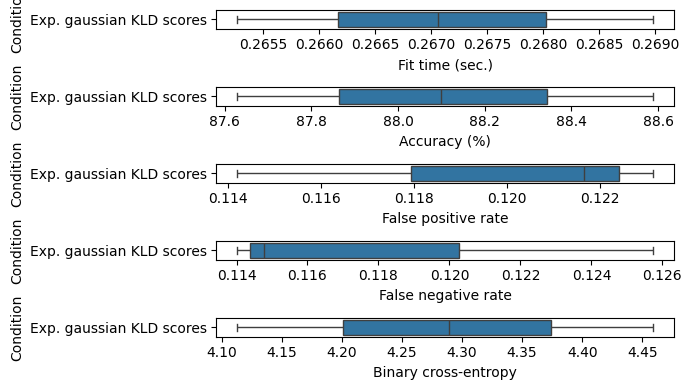

CPU times: user 1.56 s, sys: 1.33 s, total: 2.9 s
Wall time: 3.19 s


In [6]:
%%time

# Instantiate an XGBoost model using the sklearn API
model = XGBClassifier(random_state = random_state)

print(f'Model is: {type(model)}\n')

# Run cross-validation
scores = cross_validate(
    model,
    features_train,
    labels_train,
    cv = kfolds,
    n_jobs = parallel_jobs,
    scoring = scoring
)

# Collect and plot the results
results = helper_funcs.add_cv_scores(results, scores, 'Exp. gaussian KLD scores')
plot_funcs.plot_cross_validation(plots, results).show()

## 3. Kernel density estimate Kullback-Leibler divergences

In [7]:
# Drop exponential gaussian derived Kullback-Leibler scores
feature_drops = [
    'Synthetic-human perplexity ratio exponential gaussian fit Kullback-Leibler score',
    'Human-synthetic perplexity ratio exponential gaussian fit Kullback-Leibler score',
    'Synthetic-human TF-IDF exponential gaussian fit Kullback-Leibler score',
    'Human-synthetic TF-IDF exponential gaussian fit Kullback-Leibler score'
]

# Make a numpy copy
features_train = features_train_df.drop(feature_drops, axis = 1).to_numpy()
features_test = features_test_df.drop(feature_drops, axis = 1).to_numpy()

Model is: <class 'xgboost.sklearn.XGBClassifier'>



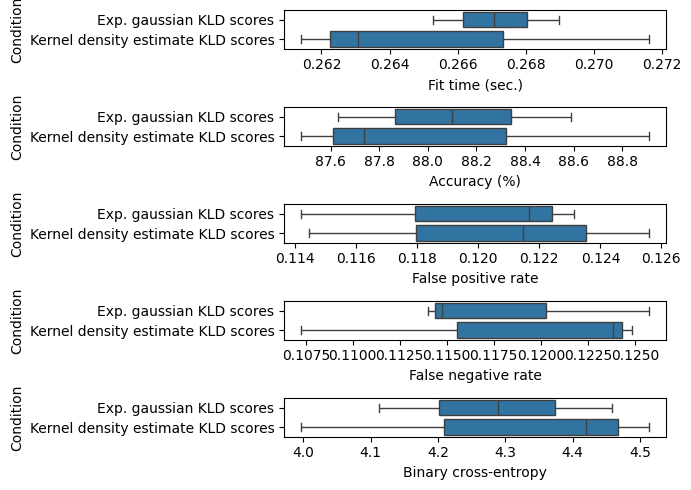

CPU times: user 1.01 s, sys: 234 ms, total: 1.24 s
Wall time: 2.85 s


In [8]:
%%time

# Instantiate an XGBoost model using the sklearn API
model = XGBClassifier(random_state = random_state)

print(f'Model is: {type(model)}\n')

# Run cross-validation
scores = cross_validate(
    model,
    features_train,
    labels_train,
    cv = kfolds,
    n_jobs = parallel_jobs,
    scoring = scoring
)

# Collect and plot the results
results = helper_funcs.add_cv_scores(results, scores, 'Kernel density estimate KLD scores')
plot_funcs.plot_cross_validation(plots, results).show()

## 4. Kernel density estimate Kullback-Leibler divergences: human-synthetic only

In [9]:
# Drop exponential gaussian derived Kullback-Leibler scores
feature_drops = [
    'Synthetic-human perplexity ratio exponential gaussian fit Kullback-Leibler score',
    'Human-synthetic perplexity ratio exponential gaussian fit Kullback-Leibler score',
    'Synthetic-human TF-IDF exponential gaussian fit Kullback-Leibler score',
    'Human-synthetic TF-IDF exponential gaussian fit Kullback-Leibler score',
    'Synthetic-human perplexity ratio kernel density estimate Kullback-Leibler score',
    'Synthetic-human TF-IDF kernel density estimate Kullback-Leibler score'
]

# Make a numpy copy
features_train = features_train_df.drop(feature_drops, axis = 1).to_numpy()
features_test = features_test_df.drop(feature_drops, axis = 1).to_numpy()

Model is: <class 'xgboost.sklearn.XGBClassifier'>



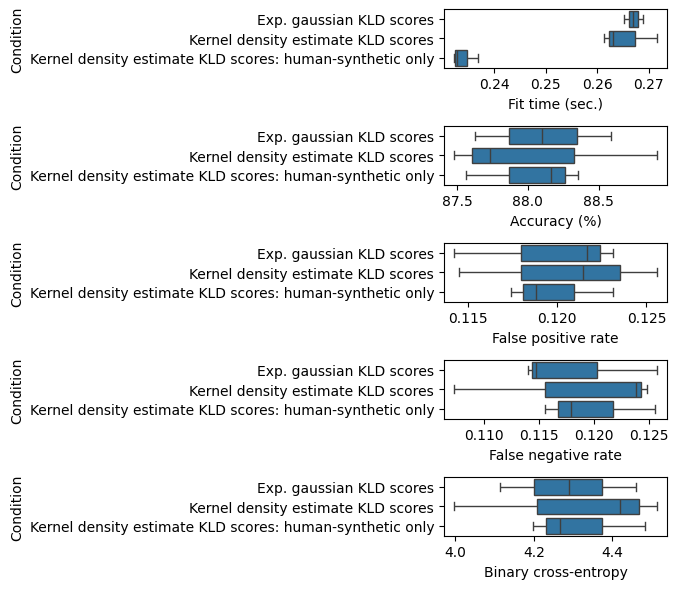

CPU times: user 1.08 s, sys: 330 ms, total: 1.41 s
Wall time: 2.9 s


In [10]:
%%time

# Instantiate an XGBoost model using the sklearn API
model = XGBClassifier(random_state = random_state)

print(f'Model is: {type(model)}\n')

# Run cross-validation
scores = cross_validate(
    model,
    features_train,
    labels_train,
    cv = kfolds,
    n_jobs = parallel_jobs,
    scoring = scoring
)

# Collect and plot the results
results = helper_funcs.add_cv_scores(results, scores, 'Kernel density estimate KLD scores: human-synthetic only')
plot_funcs.plot_cross_validation(plots, results).show()

## 5. Kernel density estimate Kullback-Leibler divergences: synthetic-human only

In [11]:
# Drop exponential gaussian derived Kullback-Leibler scores
feature_drops = [
    'Synthetic-human perplexity ratio exponential gaussian fit Kullback-Leibler score',
    'Human-synthetic perplexity ratio exponential gaussian fit Kullback-Leibler score',
    'Synthetic-human TF-IDF exponential gaussian fit Kullback-Leibler score',
    'Human-synthetic TF-IDF exponential gaussian fit Kullback-Leibler score',
    'Human-synthetic perplexity ratio kernel density estimate Kullback-Leibler score',
    'Human-synthetic TF-IDF kernel density estimate Kullback-Leibler score'
]

# Make a numpy copy
features_train = features_train_df.drop(feature_drops, axis = 1).to_numpy()
features_test = features_test_df.drop(feature_drops, axis = 1).to_numpy()

Model is: <class 'xgboost.sklearn.XGBClassifier'>



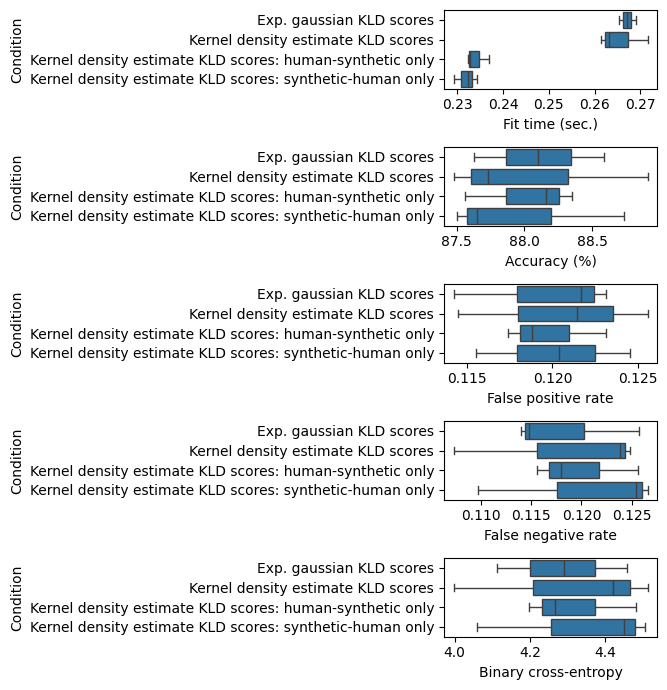

CPU times: user 1.16 s, sys: 242 ms, total: 1.4 s
Wall time: 2.92 s


In [12]:
%%time

# Instantiate an XGBoost model using the sklearn API
model = XGBClassifier(random_state = random_state)

print(f'Model is: {type(model)}\n')

# Run cross-validation
scores = cross_validate(
    model,
    features_train,
    labels_train,
    cv = kfolds,
    n_jobs = parallel_jobs,
    scoring = scoring
)

# Collect and plot the results
results = helper_funcs.add_cv_scores(results, scores, 'Kernel density estimate KLD scores: synthetic-human only')
plot_funcs.plot_cross_validation(plots, results).show()

## 6. Exponential gaussian Kullback-Leibler divergences: human-synthetic only

In [13]:
# Drop exponential gaussian derived Kullback-Leibler scores
feature_drops = [
    'Synthetic-human perplexity ratio kernel density estimate Kullback-Leibler score',
    'Human-synthetic perplexity ratio kernel density estimate Kullback-Leibler score',
    'Synthetic-human TF-IDF kernel density estimate Kullback-Leibler score',
    'Human-synthetic TF-IDF kernel density estimate Kullback-Leibler score',
    'Synthetic-human perplexity ratio exponential gaussian fit Kullback-Leibler score',
    'Synthetic-human TF-IDF exponential gaussian fit Kullback-Leibler score'
]

# Make a numpy copy
features_train = features_train_df.drop(feature_drops, axis = 1).to_numpy()
features_test = features_test_df.drop(feature_drops, axis = 1).to_numpy()

Model is: <class 'xgboost.sklearn.XGBClassifier'>



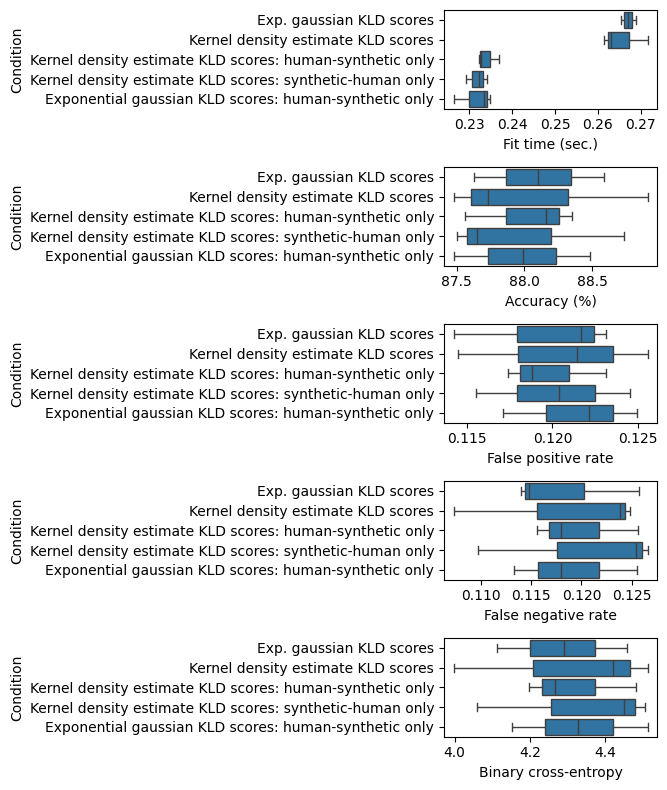

CPU times: user 1.17 s, sys: 307 ms, total: 1.48 s
Wall time: 2.95 s


In [14]:
%%time

# Instantiate an XGBoost model using the sklearn API
model = XGBClassifier(random_state = random_state)

print(f'Model is: {type(model)}\n')

# Run cross-validation
scores = cross_validate(
    model,
    features_train,
    labels_train,
    cv = kfolds,
    n_jobs = parallel_jobs,
    scoring = scoring
)

# Collect and plot the results
results = helper_funcs.add_cv_scores(results, scores, 'Exponential gaussian KLD scores: human-synthetic only')
plot_funcs.plot_cross_validation(plots, results).show()

## 7. Exponential gaussian Kullback-Leibler divergences: synthetic-human only

In [15]:
# Drop exponential gaussian derived Kullback-Leibler scores
feature_drops = [
    'Synthetic-human perplexity ratio kernel density estimate Kullback-Leibler score',
    'Human-synthetic perplexity ratio kernel density estimate Kullback-Leibler score',
    'Synthetic-human TF-IDF kernel density estimate Kullback-Leibler score',
    'Human-synthetic TF-IDF kernel density estimate Kullback-Leibler score',
    'Human-synthetic perplexity ratio exponential gaussian fit Kullback-Leibler score',
    'Human-synthetic TF-IDF exponential gaussian fit Kullback-Leibler score'
]

# Make a numpy copy
features_train = features_train_df.drop(feature_drops, axis = 1).to_numpy()
features_test = features_test_df.drop(feature_drops, axis = 1).to_numpy()

Model is: <class 'xgboost.sklearn.XGBClassifier'>



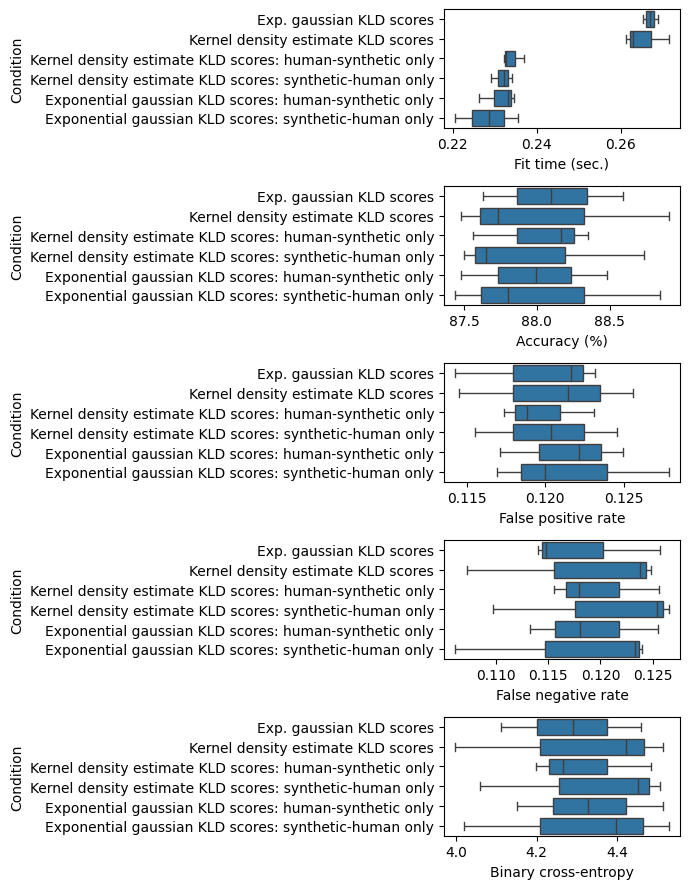

CPU times: user 1.36 s, sys: 298 ms, total: 1.66 s
Wall time: 3.12 s


In [16]:
%%time

# Instantiate an XGBoost model using the sklearn API
model = XGBClassifier(random_state = random_state)

print(f'Model is: {type(model)}\n')

# Run cross-validation
scores = cross_validate(
    model,
    features_train,
    labels_train,
    cv = kfolds,
    n_jobs = parallel_jobs,
    scoring = scoring
)

# Collect and plot the results
results = helper_funcs.add_cv_scores(results, scores, 'Exponential gaussian KLD scores: synthetic-human only')
plot_funcs.plot_cross_validation(plots, results).show()

Looks like human-synthetic KLD score alone generated with the kernel density estimate is the winner. Let's rebuild the training data accordingly

In [17]:
# Pull data from feature engineering class instance
training_data_df = data.training.all.combined.copy()
testing_data_df = data.testing.all.combined.copy()

# Drop un-trainable features
feature_drops = [
    'Source record num',
    'Dataset',
    'Generator',
    'String',
    'Reader time (seconds)',
    'Writer time (seconds)',
    'Reader peak memory (GB)',
    'Writer peak memory (GB)',
    'Fragment length (words)',
    'Synthetic-human perplexity ratio exponential gaussian fit Kullback-Leibler score',
    'Human-synthetic perplexity ratio exponential gaussian fit Kullback-Leibler score',
    'Synthetic-human TF-IDF exponential gaussian fit Kullback-Leibler score',
    'Human-synthetic TF-IDF exponential gaussian fit Kullback-Leibler score',
    'Synthetic-human perplexity ratio kernel density estimate Kullback-Leibler score',
    'Synthetic-human TF-IDF kernel density estimate Kullback-Leibler score'
]

training_data_df.drop(feature_drops, axis = 1, inplace = True)
testing_data_df.drop(feature_drops, axis = 1, inplace = True)

# Split the data into features and labels
labels_train = training_data_df['Source']
features_train_df = training_data_df.drop('Source', axis = 1)

labels_test = testing_data_df['Source']
features_test_df = testing_data_df.drop('Source', axis = 1)

# Encode string class values as integers
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(labels_train)
labels_train = label_encoder.transform(labels_train)
labels_test = label_encoder.transform(labels_test)

# Make a numpy copy
features_train = features_train_df.to_numpy()
features_test = features_test_df.to_numpy()

print(f'Training data: {len(labels_train)} examples')
print(f'Test data: {len(features_test)} examples')

Training data: 14015 examples
Test data: 3504 examples


## 8. Synthetic features

Model is: <class 'xgboost.sklearn.XGBClassifier'>



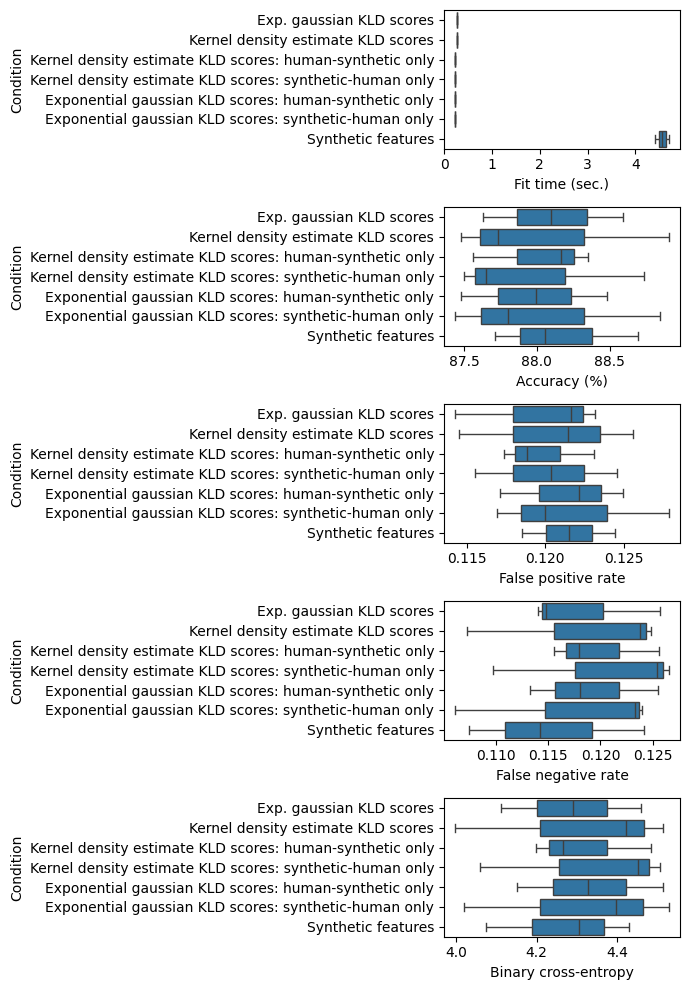

CPU times: user 1.28 s, sys: 376 ms, total: 1.66 s
Wall time: 6.12 s


In [18]:
%%time

# Perform a polynomial features transform of the dataset
trans = PolynomialFeatures(degree = 3)
poly_features = trans.fit_transform(features_train) 

# Instantiate an XGBoost model using the sklearn API
model = XGBClassifier(random_state = random_state)

print(f'Model is: {type(model)}\n')

# Run cross-validation
scores = cross_validate(
    model,
    poly_features,
    labels_train,
    cv = kfolds,
    n_jobs = parallel_jobs,
    scoring = scoring
)

# Collect and plot the results
results = helper_funcs.add_cv_scores(results, scores, 'Synthetic features')
plot_funcs.plot_cross_validation(plots, results).show()

OK, adding synthetic features does not seem to help.

## 3. Fragment length tiling

Plan here is to break the data into chunks based on fragment length and then train a classifier for each bin. Let's see if it works.

In [28]:
# Clip the data at 600 tokens
training_data_df = training_data_df[training_data_df['Fragment length (tokens)'] <= 600]

# Clip the data at 100 tokens
training_data_df = training_data_df[training_data_df['Fragment length (tokens)'] >= 101]

# Bin the data
bins = pd.cut(training_data_df.loc[:, 'Fragment length (tokens)'], 5)

training_data_df.loc[:, 'Length bin (tokens)'] = bins
training_data_df = training_data_df.astype({'Length bin (tokens)': str})

training_data_df.info()
training_data_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 10135 entries, 0 to 14014
Data columns (total 11 columns):
 #   Column                                                                           Non-Null Count  Dtype  
---  ------                                                                           --------------  -----  
 0   Fragment length (tokens)                                                         10135 non-null  int64  
 1   Source                                                                           10135 non-null  object 
 2   Perplexity                                                                       10135 non-null  float64
 3   Cross-perplexity                                                                 10135 non-null  float64
 4   Perplexity ratio score                                                           10135 non-null  float64
 5   Human-synthetic perplexity ratio kernel density estimate Kullback-Leibler score  10135 non-null  float64
 6   Human TF-ID

,Fragment length (tokens),Source,Perplexity,Cross-perplexity,Perplexity ratio score,Human-synthetic perplexity ratio kernel density estimate Kullback-Leibler score,Human TF-IDF,Synthetic TF-IDF,TF-IDF score,Human-synthetic TF-IDF kernel density estimate Kullback-Leibler score,Length bin (tokens)
0,483,synthetic,2.127,2.605469,0.816342,0.330010,-3.045396,-3.226966,-1.138871,0.033335,"(398.0, 497.0]"
1,199,human,2.336,2.417969,0.966074,2.643154,-3.078809,-3.111477,-0.202223,0.028589,"(100.505, 200.0]"
5,166,synthetic,2.412,2.863281,0.842428,0.203402,-3.585689,-3.509543,0.540274,0.069495,"(100.505, 200.0]"
6,103,human,2.379,2.478516,0.959811,2.344425,-3.589055,-3.498662,0.640684,0.077913,"(100.505, 200.0]"
7,359,human,2.750,2.750000,1.000000,3.625876,-3.353913,-3.216818,0.900817,0.098114,"(299.0, 398.0]"


In [29]:
# Reset dictionary to hold testing/experimentation results
results = {
    'Fold': [],
    'Condition': [],
    'Fit time (sec.)': [],
    'Accuracy (%)': [],
    'False positive rate': [],
    'False negative rate': [],
    'Binary cross-entropy': []
}

In [30]:
# Grab the bin strings
bin_strings = list(training_data_df['Length bin (tokens)'].unique())
bin_strings.sort()
print(bin_strings)

['(100.505, 200.0]', '(200.0, 299.0]', '(299.0, 398.0]', '(398.0, 497.0]', '(497.0, 596.0]']


Bin: (100.505, 200.0]
Training data: 3462 examples
Model is: <class 'xgboost.sklearn.XGBClassifier'>

Bin: (200.0, 299.0]
Training data: 2730 examples
Model is: <class 'xgboost.sklearn.XGBClassifier'>

Bin: (299.0, 398.0]
Training data: 2248 examples
Model is: <class 'xgboost.sklearn.XGBClassifier'>

Bin: (398.0, 497.0]
Training data: 1488 examples
Model is: <class 'xgboost.sklearn.XGBClassifier'>

Bin: (497.0, 596.0]
Training data: 207 examples
Model is: <class 'xgboost.sklearn.XGBClassifier'>



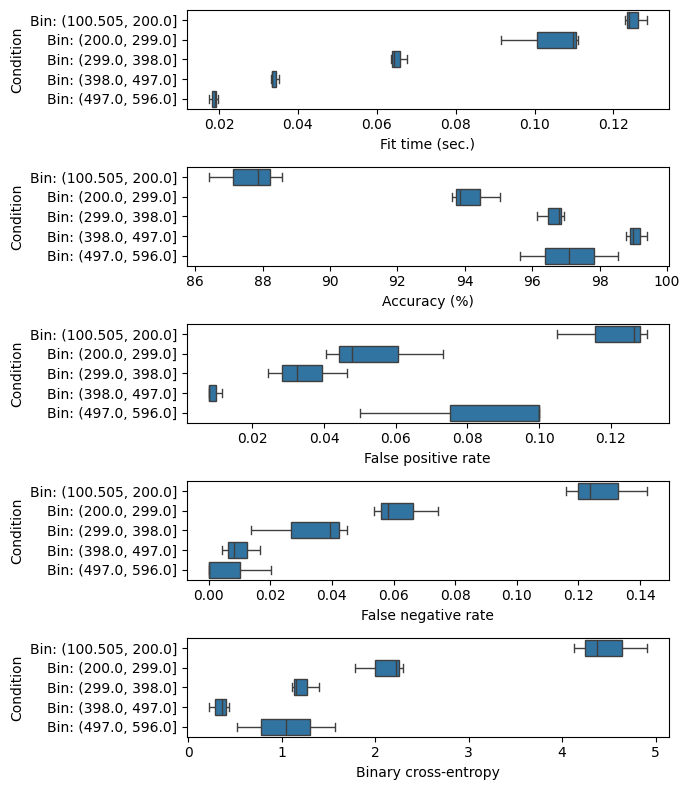

In [31]:
# Loop on the bins
for bin_string in bin_strings:
    print(f'Bin: {bin_string}')

    # Grab the data for this bin
    bin_training_data = training_data_df[training_data_df['Length bin (tokens)'] == bin_string]

    # Split the data into features and labels
    labels_train = bin_training_data['Source']
    features_train_df = bin_training_data.drop('Source', axis = 1)

    # Encode string class values as integers
    label_encoder = LabelEncoder()
    label_encoder = label_encoder.fit(labels_train)
    labels_train = label_encoder.transform(labels_train)

    # Drop the bin string and make a numpy copy
    features_train_df = features_train_df.drop('Length bin (tokens)', axis = 1)
    features_train = features_train_df.to_numpy()

    print(f'Training data: {len(labels_train)} examples')

    # Instantiate an XGBoost model using the sklearn API
    model = XGBClassifier(random_state = random_state)

    print(f'Model is: {type(model)}\n')

    # Run cross-validation
    scores = cross_validate(
        model,
        features_train,
        labels_train,
        cv = kfolds,
        n_jobs = parallel_jobs,
        scoring = scoring
    )

    # Collect and plot the results
    results = helper_funcs.add_cv_scores(results, scores, f'Bin: {bin_string}')

plot_funcs.plot_cross_validation(plots, results).show()

So, I think this might have potential - it's the short fragments that are killing our accuracy. What I don't know is if we were to build a compound classifier out of models trained on each bin, would it do any better overall than one classifier trained with length as a feature. Seems like it could - the short bin gives 88% accuracy, which is about what we get with a single classifier. The other long bins score in the mid/high 90s and contain more data together than the short bin.